# Import Dependensi dan Variabel

In [411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Import Data

In [412]:
df_gravimetri = pd.read_csv('hasil/ET Aktual Gravimetri.csv')
df_bc = pd.read_csv('hasil/Estimasi ET Blaney-Criddle.csv')
df_hs = pd.read_csv('hasil/Estimasi ET Hargreaves-Samani.csv')
df_pm = pd.read_csv('hasil/Estimasi ET Penman-Monteith.csv')

# Plot Gravimetri

In [413]:
df_gravimetri

,Num Day,A1,A2,A3,A4,B1,B2,B3,B4,C1,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
0,day 05,14.080,8.384,14.560,20.992,3.622222,8.111111,6.377778,9.222222,17.926531,...,10.62500,15.77500,1.846914,4.918519,1.037037,1.046914,3.896,1.432,1.936,4.816
1,day 06,2.014,8.190,6.526,10.334,10.207778,7.541111,7.096667,6.096667,8.225918,...,8.69250,3.26750,3.091728,6.301605,2.380617,6.439877,1.490,2.658,1.930,4.378
2,day 07,13.504,12.944,9.376,11.072,9.755556,12.122222,10.577778,9.244444,8.383673,...,6.75000,3.26875,7.664198,10.558025,8.281481,7.550617,0.092,1.780,3.716,5.316
3,day 08,11.776,7.104,10.368,11.456,11.088889,14.755556,9.777778,8.533333,8.669388,...,7.82500,15.31250,3.644444,7.733333,5.985185,8.296296,0.416,0.848,1.440,1.200
4,day 09,9.602,8.962,9.378,10.306,14.745556,13.412222,11.845556,8.778889,12.771633,...,5.34625,8.65875,4.546790,7.825802,6.423333,4.818395,1.534,1.502,2.226,1.846
5,day 10,11.094,9.046,11.510,11.862,15.572222,15.194444,13.838889,11.705556,10.664286,...,8.31250,9.67500,6.164815,8.870988,5.463580,4.594444,0.870,4.414,7.646,9.782
6,day 12,9.412,9.668,11.012,12.452,12.300000,13.077778,12.322222,9.211111,11.365306,...,8.60000,13.83750,10.628395,10.993827,11.013580,8.356790,4.524,4.164,5.684,5.556
7,day 13,12.146,13.298,13.202,14.130,18.187778,19.365556,7.210000,15.921111,15.344694,...,12.86000,12.83500,15.785309,11.953210,10.975432,11.844568,8.618,6.618,9.210,8.154
8,day 14,13.168,13.232,12.016,11.760,16.786667,16.208889,14.320000,13.453333,12.442449,...,11.63250,7.23250,13.361975,11.929877,11.791605,13.243457,4.360,7.032,8.224,8.272
9,day 15,9.088,8.592,10.560,9.520,12.533333,11.955556,13.122222,7.000000,11.248980,...,6.71875,6.58750,9.911111,6.627160,7.501235,8.098765,0.612,6.408,2.804,2.124


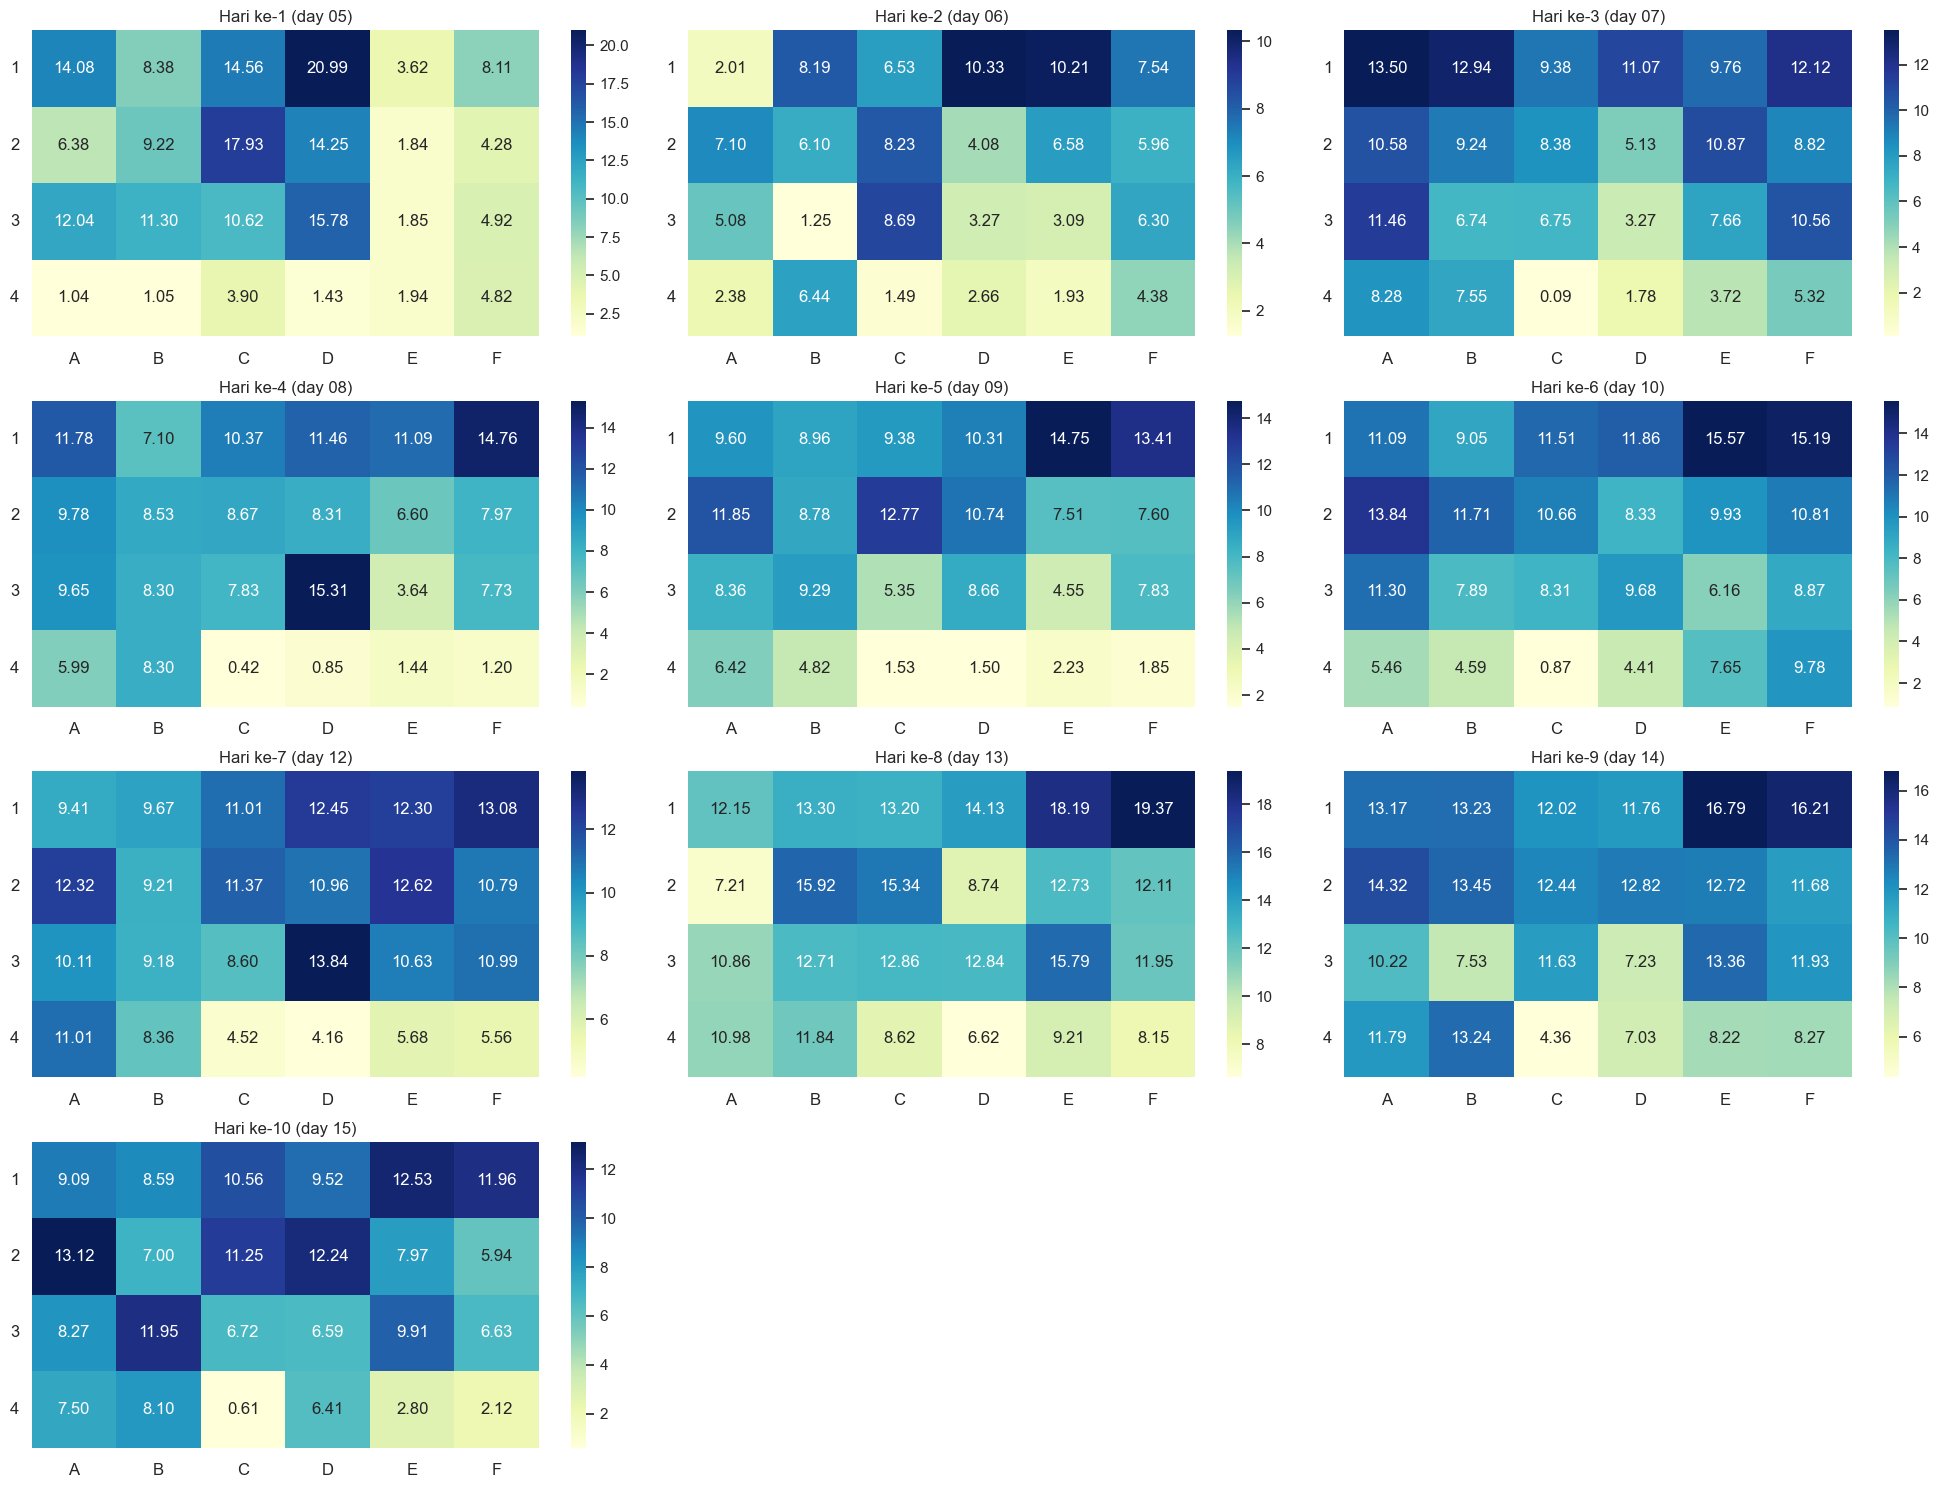

In [414]:
df_gravimetri.set_index('Num Day', inplace=True)

# Plot heatmaps
fig, axes = plt.subplots(4, 3, figsize=(20, 15))  # 4x3 grid
axes = axes.flatten()

for i, (day, data) in enumerate(df_gravimetri.iterrows()):
    # Reshape data untuk heatmap
    day_data = data.values.reshape(4, 6)  # Reshape ke (4x6)
    
    # Plot heatmap
    sns.heatmap(
        day_data, annot=True, fmt=".2f", cmap="YlGnBu",
        xticklabels=[], yticklabels=[], ax=axes[i]
    )
    axes[i].set_title(f"Hari ke-{i+1} ({day})")

    # Tambahkan label X (A-F) dan Y (1-4)
    for col in range(6):
        axes[i].text(col + 0.5, 4.3, f"{chr(65 + col)}", ha="center", va="center", fontsize=12)
    for row in range(4):
        axes[i].text(-0.2, row + 0.5, f"{row + 1}", ha="center", va="center", fontsize=12)

# Hilangkan subplot kosong jika jumlah hari kurang dari 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Plot Metode Estimasi

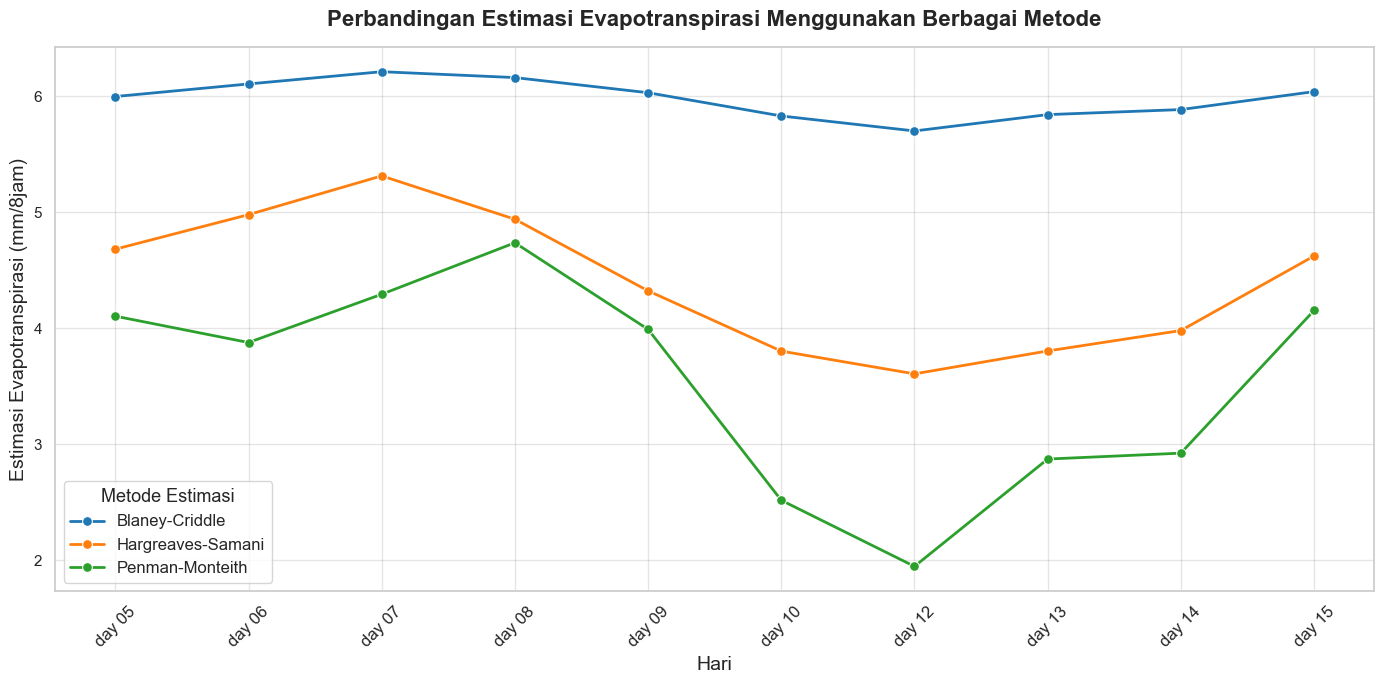

In [415]:
sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(14, 7))

# Plot data Blaney-Criddle
sns.lineplot(
  x=df_bc['Num Day'], y=df_bc['ET Total'], marker='o', label='Blaney-Criddle', color='#1f77b4', markersize=7, linewidth=2)

# Plot data Hargreaves-Samani
sns.lineplot(x=df_hs['Num Day'], y=df_hs['ET Total'], marker='o', label='Hargreaves-Samani', color='#ff7f0e', markersize=7, linewidth=2)

# Plot data Penman-Monteith dengan
sns.lineplot(x=df_pm['Num Day'], y=df_pm['ET Total'], marker='o', label='Penman-Monteith', color='#2ca02c', markersize=7, linewidth=2)

plt.title('Perbandingan Estimasi Evapotranspirasi Menggunakan Berbagai Metode', fontsize=16, weight='bold', pad=15)
plt.xlabel('Hari', fontsize=14)
plt.ylabel('Estimasi Evapotranspirasi (mm/8jam)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)

plt.grid(True, linestyle='-', color='gray', alpha=0.2)
plt.legend(
  title='Metode Estimasi', 
  fontsize=12, 
  title_fontsize='13', 
  frameon=True
)

plt.tight_layout()
plt.show()

# Analisis Parameter

In [416]:
# Pastikan kolom aktual adalah numerik
aktual = df_gravimetri.apply(pd.to_numeric, errors='coerce')

# Pastikan estimasi juga numerik
estimasi_bc = np.array(df_bc['ET Total'], dtype=float)
estimasi_hs = np.array(df_hs['ET Total'], dtype=float)
estimasi_pm = np.array(df_pm['ET Total'], dtype=float)

## Akurasi

In [417]:
# Fungsi menghitung akurasi
def akurasi(aktual, estimasi):
  error = np.abs(np.mean(estimasi) - np.mean(aktual)) / np.mean(aktual)
  akurasi = (1 - error) * 100
  return akurasi


In [418]:
akurasi_bc = {}
akurasi_hs = {}
akurasi_pm = {}

for col in aktual.columns:
    akurasi_bc[col] = akurasi(aktual[col], estimasi_bc)
    akurasi_hs[col] = akurasi(aktual[col], estimasi_hs)
    akurasi_pm[col] = akurasi(aktual[col], estimasi_pm)
    

df_akurasi = pd.DataFrame({
    'Akurasi Blanet-Criddle': akurasi_bc,
    'Akurasi Hargreaves-Samani': akurasi_hs,
    'Akurasi Penman-Monteith': akurasi_pm
}).T

df_akurasi.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
Akurasi Blanet-Criddle,56.489839,60.162644,55.123770,48.282022,47.927645,45.401308,56.168959,60.316337,51.104102,62.575716,...,68.466105,62.015242,78.039234,68.193024,84.419330,80.513664,-26.464110,37.709733,66.534941,83.730463
Akurasi Hargreaves-Samani,41.606559,44.311697,40.600407,35.561242,35.300232,33.439504,41.370221,44.424897,37.639793,46.089001,...,50.427459,45.676194,57.478373,50.226327,62.177516,59.300869,33.201995,80.468067,98.301252,85.636205
Akurasi Penman-Monteith,33.443235,35.617617,32.634492,28.584026,28.374227,26.878579,33.253267,35.708607,30.254759,37.046209,...,40.533449,36.714396,46.200954,40.371780,49.978112,47.665872,65.928234,96.079430,79.014269,68.834140


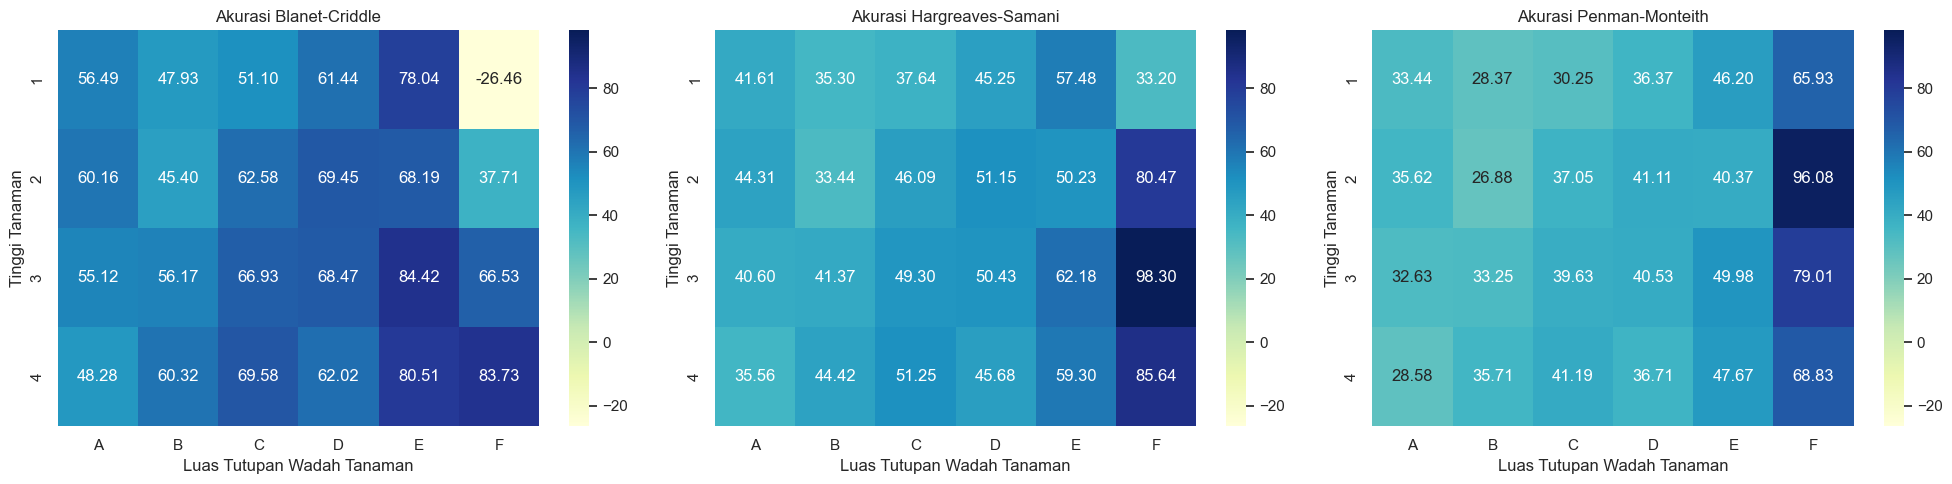

In [419]:
# Pastikan kolom dataframe dalam format string
df_akurasi.columns = df_akurasi.columns.astype(str)

# Ekstraksi kategori (A-F) dan nomor (1-4) dari kolom
df_akurasi.columns = [col[0] + col[1] for col in df_akurasi.columns.str.extract(r'([A-F])([1-4])').values]
df_akurasi.index.name = "Metode"

# Reshape data
df_akurasi_long = df_akurasi.reset_index().melt(id_vars="Metode", var_name="CategoryNumber", value_name="Akurasi")
df_akurasi_long[['Category', 'Number']] = df_akurasi_long['CategoryNumber'].str.extract(r'([A-F])([1-4])')
df_akurasi_long.drop(columns=['CategoryNumber'], inplace=True)

# Menentukan rentang warna (vmin, vmax) berdasarkan data keseluruhan
vmin = df_akurasi_long['Akurasi'].min()
vmax = df_akurasi_long['Akurasi'].max()

# Generate heatmaps untuk setiap metode
methods = df_akurasi.index
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, method in enumerate(methods):
    # Filter data untuk metode tertentu
    heatmap_data = df_akurasi_long[df_akurasi_long['Metode'] == method].pivot(index="Number", columns="Category", values="Akurasi")
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax, ax=axes[i])
    axes[i].set_title(method)
    axes[i].set_xlabel("Luas Tutupan Wadah Tanaman")
    axes[i].set_ylabel("Tinggi Tanaman")

plt.tight_layout()
plt.show()

## Mean Absolute Error (MAE)

In [420]:
mae_bc = {}
mae_hs = {}
mae_pm = {}

# Menghitung MSE untuk setiap kolom
for col in aktual.columns:
    mae_bc[col] = mean_absolute_error(aktual[col], estimasi_bc)
    mae_hs[col] = mean_absolute_error(aktual[col], estimasi_bc)
    mae_pm[col] = mean_absolute_error(aktual[col], estimasi_bc)

df_mae = pd.DataFrame({
    'MAE BC': mae_bc,
    'MAE HS': mae_hs,
    'MAE PM': mae_pm
}).T

df_mae.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
MAE BC,5.425614,3.96063,4.86943,6.40703,6.973928,7.193074,4.667519,3.937347,5.722916,4.200053,...,2.891924,4.820293,3.91705,3.005903,2.950365,2.927905,3.895264,2.753476,3.003887,2.566687
MAE HS,5.425614,3.96063,4.86943,6.40703,6.973928,7.193074,4.667519,3.937347,5.722916,4.200053,...,2.891924,4.820293,3.91705,3.005903,2.950365,2.927905,3.895264,2.753476,3.003887,2.566687
MAE PM,5.425614,3.96063,4.86943,6.40703,6.973928,7.193074,4.667519,3.937347,5.722916,4.200053,...,2.891924,4.820293,3.91705,3.005903,2.950365,2.927905,3.895264,2.753476,3.003887,2.566687


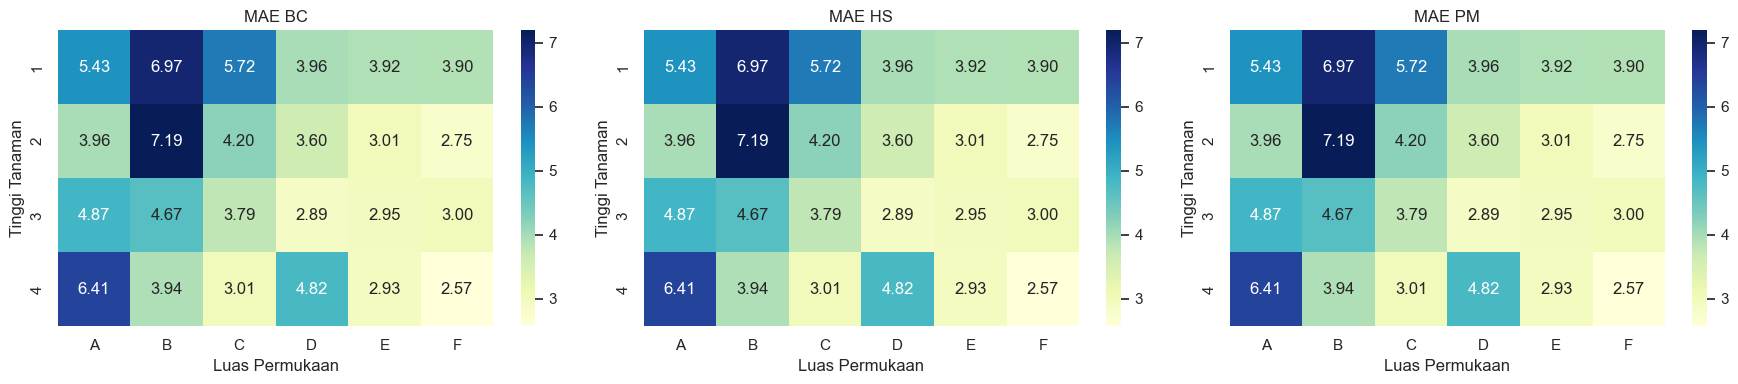

In [421]:
# 2. Mendapatkan sumbu X dan Y (karakter pertama dan kedua dari kode)
x_labels = sorted(set(col[0] for col in df_mae.columns))  # Karakter pertama (A, B, C...)
y_labels = sorted(set(col[1] for col in df_mae.columns))  # Karakter kedua (1, 2, 3...)

# 3. Membuat subplot heatmap untuk setiap "day"
n_days = len(df_mae)  # Jumlah baris di df_mae (setiap baris mewakili satu hari)
ncols, nrows = 3, int(np.ceil(n_days / ncols))  # Tentukan jumlah kolom dan baris
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))  # Membuat subplot secara langsung

# 4. Loop untuk membuat heatmap setiap hari
for i, (day, row) in enumerate(df_mae.iterrows()):
    ax = axes.flatten()[i]  # Ambil subplot sesuai index
    day_matrix = np.array([[row[f"{x}{y}"] for x in x_labels] for y in y_labels])  # Matriks heatmap
    sns.heatmap(day_matrix, cmap='YlGnBu', xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt=".2f", cbar=True, ax=ax)
    ax.set_title(f'{day}')
    ax.set_xlabel('Luas Permukaan')
    ax.set_ylabel('Tinggi Tanaman')

# Menyesuaikan tampilan plot
plt.tight_layout()
plt.show()


# Root Mean Square Error (RMSE)

In [422]:
rmse_bc = {}
rmse_hs = {}
rmse_pm = {}

# Menghitung RMSE untuk setiap kolom
for col in aktual.columns:
    rmse_bc[col] = np.sqrt(mean_squared_error(aktual[col], estimasi_bc))
    rmse_hs[col] = np.sqrt(mean_squared_error(aktual[col], estimasi_hs))
    rmse_pm[col] = np.sqrt(mean_squared_error(aktual[col], estimasi_pm))

# Membuat dataframe untuk RMSE
df_rmse = pd.DataFrame({
    'RMSE BC': rmse_bc,
    'RMSE HS': rmse_hs,
    'RMSE PM': rmse_pm
}).T

# Menampilkan hasil
df_rmse.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
RMSE BC,5.683326,4.549071,5.338363,7.140102,7.661853,7.976641,5.460430,4.892291,6.473288,4.784182,...,3.590229,5.787187,4.807191,3.704571,3.669826,3.679922,4.265515,3.279853,3.279383,2.989025
RMSE HS,7.068257,6.034509,6.883853,8.604814,9.177137,9.531951,6.946227,6.373076,7.979068,6.163715,...,5.007723,7.012228,5.772969,5.130901,4.611998,4.664640,3.422837,2.724781,3.250703,3.219352
RMSE PM,7.832763,6.921302,7.723012,9.430036,10.004318,10.363537,7.792202,7.207630,8.780380,6.889894,...,5.858407,7.666103,6.451142,6.012127,5.305463,5.365628,3.241586,2.842280,3.649634,3.812861


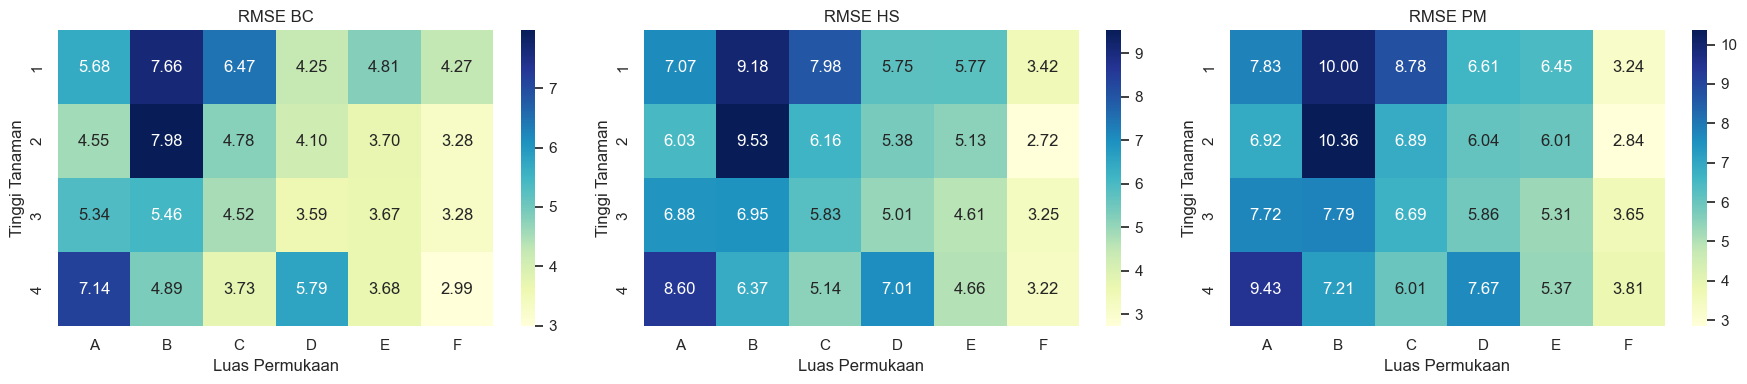

In [423]:
# 2. Mendapatkan sumbu X dan Y (karakter pertama dan kedua dari kode)
x_labels = sorted(set(col[0] for col in df_rmse.columns))  # Karakter pertama (A, B, C...)
y_labels = sorted(set(col[1] for col in df_rmse.columns))  # Karakter kedua (1, 2, 3...)

# 3. Membuat subplot heatmap untuk setiap "day"
n_days = len(df_rmse)  # Jumlah baris di df_rmse (setiap baris mewakili satu hari)
ncols, nrows = 3, int(np.ceil(n_days / ncols))  # Tentukan jumlah kolom dan baris
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))  # Membuat subplot secara langsung

# 4. Loop untuk membuat heatmap setiap hari
for i, (day, row) in enumerate(df_rmse.iterrows()):
    ax = axes.flatten()[i]  # Ambil subplot sesuai index
    day_matrix = np.array([[row[f"{x}{y}"] for x in x_labels] for y in y_labels])  # Matriks heatmap
    sns.heatmap(day_matrix, cmap='YlGnBu', xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt=".2f", cbar=True, ax=ax)
    ax.set_title(f'{day}')
    ax.set_xlabel('Luas Permukaan')
    ax.set_ylabel('Tinggi Tanaman')

# Menyesuaikan tampilan plot
plt.tight_layout()
plt.show()


# Mean Bias Error (MBE)

In [424]:
mbe_bc = {}
mbe_hs = {}
mbe_pm = {}

# Menghitung MBE untuk setiap kolom
for col in aktual.columns:
    mbe_bc[col] = np.mean(estimasi_bc - aktual[col])
    mbe_hs[col] = np.mean(estimasi_hs - aktual[col])
    mbe_pm[col] = np.mean(estimasi_pm - aktual[col])

# Membuat dataframe untuk MBE
df_mbe = pd.DataFrame({
    'MBE BC': mbe_bc,
    'MBE HS': mbe_hs,
    'MBE PM': mbe_pm
}).T

# Menampilkan hasil
df_mbe.head()


,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
MBE BC,-4.607030,-3.960630,-4.869430,-6.407030,-6.498630,-7.193074,-4.667519,-3.935297,-5.722916,-3.577242,...,-2.754880,-3.663630,-1.683198,-2.789864,-1.103939,-1.447642,3.340170,2.295770,1.499770,0.836970
MBE HS,-6.182931,-5.536531,-6.445331,-7.982931,-8.074531,-8.768976,-6.243420,-5.511198,-7.298817,-5.153143,...,-4.330781,-5.239531,-3.259099,-4.365766,-2.679840,-3.023543,1.764269,0.719869,-0.076131,-0.738931
MBE PM,-7.047297,-6.400897,-7.309697,-8.847297,-8.938897,-9.633341,-7.107785,-6.375563,-8.163182,-6.017509,...,-5.195147,-6.103897,-4.123464,-5.230131,-3.544205,-3.887909,0.899903,-0.144497,-0.940497,-1.603297


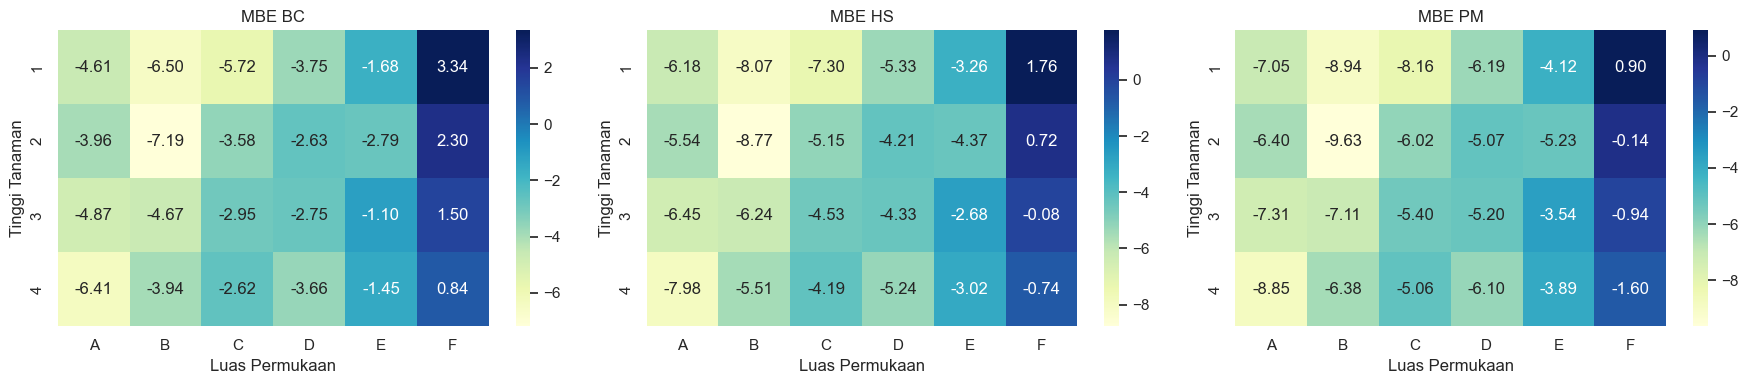

In [425]:
# 2. Mendapatkan sumbu X dan Y (karakter pertama dan kedua dari kode)
x_labels = sorted(set(col[0] for col in df_mbe.columns))
y_labels = sorted(set(col[1] for col in df_mbe.columns))

# 3. Membuat subplot heatmap untuk setiap "day"
n_days = len(df_mbe)  # Jumlah baris di df_mbe (setiap baris mewakili satu hari)
ncols, nrows = 3, int(np.ceil(n_days / ncols))  # Tentukan jumlah kolom dan baris
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))  # Membuat subplot secara langsung

# 4. Loop untuk membuat heatmap setiap hari
for i, (day, row) in enumerate(df_mbe.iterrows()):
    ax = axes.flatten()[i]  # Ambil subplot sesuai index
    day_matrix = np.array([[row[f"{x}{y}"] for x in x_labels] for y in y_labels])  # Matriks heatmap
    sns.heatmap(day_matrix, cmap='YlGnBu', xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt=".2f", cbar=True, ax=ax)
    ax.set_title(f'{day}')
    ax.set_xlabel('Luas Permukaan')
    ax.set_ylabel('Tinggi Tanaman')

# Menyesuaikan tampilan plot
plt.tight_layout()
plt.show()
